In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from time import time

from keras.models import Model, Input, load_model #model_from_json
from keras.layers import Masking, Flatten, Embedding, Dense, LSTM, TimeDistributed
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
#from keras.optimizer_v2 import rmsprop
from keras import optimizers
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import StratifiedKFold

import keras.backend as K
from keras.layers import multiply
from keras.layers.core import Dense, Reshape, Lambda, RepeatVector, Permute, Flatten


In [2]:
import lstm_preprocess

In [3]:
SEED = 39
np.random.seed(SEED)
np.random.seed(SEED)
tensorflow.random.set_seed(SEED)

NameError: name 'tensorflow' is not defined

## Read the data

In [ ]:
data = pd.read_csv("C:\\Users\\Maria\\Desktop\\data\\icd_demos_vitals.csv")

In [ ]:
#data.drop("Unnamed: 0", axis=1, inplace=True)

## Preprocess

1. padding
2. remove unnesecary columns
3. bring to the (samples, timesteps, features) format 
4. Split train, test, validation 
5. Z-normalization using mean and std from train set

## 1. padding

In [ ]:
#either keep the patients with 24 hours of admission, or change 23 to sth smaller to include patients with less time steps
df = lstm_preprocess.pad(data, 23, 24, 0)

In [ ]:
target = df[["subject_id", "hadm_id", "mortality"]]

In [ ]:
target

In [ ]:
print('There are {0} rows in the df after padding'.format(len(df)))

### here i am just doing some checks to see how many time steps a patient has 

In [ ]:
x = df.hadm_id.value_counts() == 23


In [ ]:
x[x.values == True]

In [ ]:
df[df.hadm_id == 196831]

In [ ]:
df

## 2. remove columns  

In [ ]:
#remove unnecessary columns
COLUMNS = lstm_preprocess.delete_columns(df)

In [ ]:
COLUMNS

In [ ]:
df.hadm_id.value_counts()

In [ ]:
df

## 3. reshape the matrix to the appropriate format

In [ ]:

MATRIX1 = df[COLUMNS+['mortality']]
MATRIX = df[COLUMNS+['mortality']].values
MATRIX = MATRIX.reshape(int(MATRIX.shape[0]/24),24,MATRIX.shape[1])

In [ ]:
MATRIX1 

In [ ]:
import matplotlib.pyplot as plt 
list(MATRIX1.mortality)
labels, counts = np.unique(list(MATRIX1.mortality), return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks, labels)

## 4. Split train, test, validation

In [ ]:

bool_matrix = (~MATRIX.any(axis=2))
MATRIX[bool_matrix] = np.nan
#MATRIX = lstm_preprocess.ZScoreNormalize(MATRIX)

## restore 3D shape to boolmatrix for consistency
bool_matrix = np.isnan(MATRIX)
MATRIX[bool_matrix] = 0 
   
#permutation = np.random.permutation(MATRIX.shape[0])
#MATRIX = MATRIX[permutation]
#bool_matrix = bool_matrix[permutation]

#X_MATRIX = MATRIX[:,:,0:-7]
X_MATRIX = MATRIX[:,:,0:-2]
Y_MATRIX = MATRIX[:,:,-1]
#x_bool_matrix = bool_matrix[:,:,0:-1]
#y_bool_matrix = bool_matrix[:,:,-1]

In [ ]:
np.isnan(X_MATRIX).any()

In [ ]:
#train, validation, test split

tt_split = 0.7 
val_percentage = 0.8

X_TRAIN = X_MATRIX[0:int(tt_split*X_MATRIX.shape[0]),:,:]
Y_TRAIN = Y_MATRIX[0:int(tt_split*Y_MATRIX.shape[0]),:]
Y_TRAIN = Y_TRAIN[:, 0] 
Y_TRAIN = Y_TRAIN.reshape(Y_TRAIN.shape[0], 1)
#Y_TRAIN = Y_TRAIN.reshape(Y_TRAIN.shape[0], Y_TRAIN.shape[1], 1)

X_VAL = X_MATRIX[int(tt_split*X_MATRIX.shape[0]):int(val_percentage*X_MATRIX.shape[0])]
Y_VAL = Y_MATRIX[int(tt_split*Y_MATRIX.shape[0]):int(val_percentage*Y_MATRIX.shape[0])]
Y_VAL = Y_VAL[:, 0] 
Y_VAL = Y_VAL.reshape(Y_VAL.shape[0], 1)
#Y_VAL = Y_VAL.reshape(Y_VAL.shape[0], Y_VAL.shape[1], 1)
"""
x_val_boolmat = x_bool_matrix[int(tt_split*x_bool_matrix.shape[0]):int(val_percentage*x_bool_matrix.shape[0])]
y_val_boolmat = y_bool_matrix[int(tt_split*y_bool_matrix.shape[0]):int(val_percentage*y_bool_matrix.shape[0])]
y_val_boolmat = y_val_boolmat.reshape(y_val_boolmat.shape[0],y_val_boolmat.shape[1],1)
"""
X_TEST = X_MATRIX[int(val_percentage*X_MATRIX.shape[0])::]
Y_TEST = Y_MATRIX[int(val_percentage*X_MATRIX.shape[0])::]
Y_TEST = Y_TEST[:, 0] 
Y_TEST = Y_TEST.reshape(Y_TEST.shape[0], 1)
#Y_TEST = Y_TEST.reshape(Y_TEST.shape[0], Y_TEST.shape[1], 1)
"""
x_test_boolmat = x_bool_matrix[int(val_percentage*x_bool_matrix.shape[0])::]
y_test_boolmat = y_bool_matrix[int(val_percentage*y_bool_matrix.shape[0])::]
y_test_boolmat = y_test_boolmat.reshape(y_test_boolmat.shape[0],y_test_boolmat.shape[1],1)

X_TEST[x_test_boolmat] = 0
Y_TEST[y_test_boolmat] = 0
"""

In [ ]:
Y_TRAIN

## 5. Normalize

In [ ]:
X_TRAIN, X_VAL, X_TEST = lstm_preprocess.normalize(X_TRAIN, X_TEST, X_VAL)


In [26]:
X_TRAIN.shape

(1549, 24, 34)

In [27]:
no_feature_cols = X_TRAIN.shape[2]


In [28]:
np.isnan(Y_TRAIN).any()


False

In [29]:
bool_matrix = np.isnan(X_VAL)
X_VAL[bool_matrix] = 0 
np.isnan(X_VAL).any()

False

In [30]:
bool_matrix = np.isnan(X_TRAIN)
X_TRAIN[bool_matrix] = 0 
np.isnan(X_TRAIN).any()

False

In [31]:
bool_matrix = np.isnan(X_TEST)
X_TEST[bool_matrix] = 0 
np.isnan(X_TEST).any()

False

,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose,1,2,...,19,20,F,M,18-25,25-45,45-65,65-89,89+,mortality
0,72.0,103.0,66.0,75.0,10.0,0.000000,93.0,0.0,0.0,0.0,...,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,75.0,93.0,64.0,72.0,9.0,0.000000,91.0,0.0,0.0,0.0,...,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,73.0,108.0,61.0,71.0,10.0,0.000000,94.0,0.0,0.0,0.0,...,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,75.0,107.0,59.0,71.0,18.0,0.000000,95.0,0.0,0.0,0.0,...,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,79.0,118.0,86.0,91.0,16.0,0.000000,95.0,0.0,0.0,0.0,...,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53131,81.0,103.0,54.0,67.0,17.0,36.777778,94.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
53132,79.0,111.0,52.0,65.0,19.0,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
53133,74.0,119.0,62.0,75.0,23.0,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
53134,81.0,121.0,63.0,78.0,16.0,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Assigning weights on the imbalanced class label

In [32]:
df_mor = df.groupby('hadm_id').sum("mortality")

In [33]:
df_mor = df_mor.mortality.replace({24:1})

In [34]:
df_mor

hadm_id
100061.0    1.0
100087.0    1.0
100104.0    0.0
100108.0    1.0
100156.0    0.0
           ... 
199933.0    0.0
199941.0    0.0
199976.0    0.0
199981.0    0.0
199984.0    0.0
Name: mortality, Length: 2214, dtype: float64

In [35]:
neg, pos = np.bincount(df_mor)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 2214
    Positive: 395 (17.84% of total)



In [36]:
# you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.


# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))



Weight for class 0: 0.61
Weight for class 1: 2.80


In [37]:

#results = model.evaluate(X_TRAIN, Y_TRAIN, batch_size=16, verbose=0)

#print("Loss: {:0.4f}".format(results[0]))


initial_bias = np.log([pos/neg])
initial_bias

array([-1.52715641])

## A simple LSTM

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.optimizers import RMSprop

def build_model1(no_feature_cols=None, time_steps=24, output_summary=False, output_bias=None):
  

  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 
  if output_bias is not None:
    output_bias = tensorflow.keras.initializers.Constant(output_bias) 
  
  model = keras.Sequential()
  model.add(layers.LSTM(32, input_shape = (time_steps, no_feature_cols)))
  model.add(layers.Dense(1, activation="sigmoid",  bias_initializer = output_bias))
  optimizer = tensorflow.keras.optimizers.RMSprop()
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model



In [164]:
Y_TRAIN.shape

(1549, 1)

In [165]:
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model1(no_feature_cols=no_feature_cols, time_steps=24, output_summary=False, output_bias=initial_bias)

time_steps:24|no_feature_cols:34


In [166]:
  #init callbacks
  tb_callback = TensorBoard(log_dir='.\\logs\\{0}.log'.format('LSTM'),
    histogram_freq=0,
    write_grads=False,
    write_images=True,
    write_graph=True) 

  #Make checkpoint dir and init checkpointer
  checkpoint_dir = "./saved_models/{0}".format('model_name')

  if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

  checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

  #fit
history_reg = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=16,
    epochs=100,
    callbacks=[tb_callback], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    class_weight=class_weight,
    shuffle=True)

Epoch 1/100
97/97 [==============================] - 6s 34ms/step - loss: 0.8035 - acc: 0.8063 - val_loss: 0.5656 - val_acc: 0.7207
Epoch 2/100
97/97 [==============================] - 1s 8ms/step - loss: 0.6187 - acc: 0.6966 - val_loss: 0.6330 - val_acc: 0.6171
Epoch 3/100
97/97 [==============================] - 1s 8ms/step - loss: 0.5622 - acc: 0.6953 - val_loss: 0.5908 - val_acc: 0.6712
Epoch 4/100
97/97 [==============================] - 1s 7ms/step - loss: 0.5248 - acc: 0.7340 - val_loss: 0.6239 - val_acc: 0.6577
Epoch 5/100
97/97 [==============================] - 1s 7ms/step - loss: 0.4971 - acc: 0.7527 - val_loss: 0.6273 - val_acc: 0.6667
Epoch 6/100
97/97 [==============================] - 1s 7ms/step - loss: 0.4651 - acc: 0.7650 - val_loss: 0.6174 - val_acc: 0.6712
Epoch 7/100
97/97 [==============================] - 1s 8ms/step - loss: 0.4314 - acc: 0.7954 - val_loss: 0.6430 - val_acc: 0.6712
Epoch 8/100
97/97 [==============================] - 1s 8ms/step - loss: 0.3991 - 

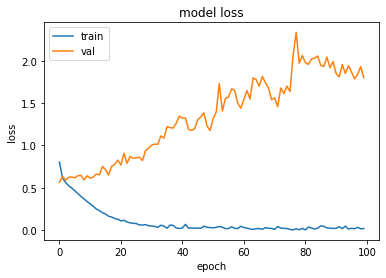

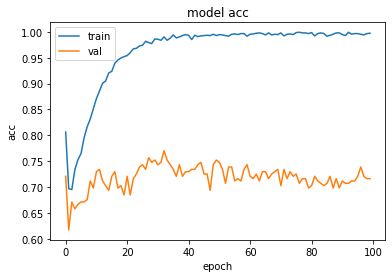

In [167]:
import matplotlib.pyplot as plt  

plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

plt.plot(history_reg.history['acc'])
plt.plot(history_reg.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();


In [176]:
print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TEST = model.predict(X_TEST)

pred = np.reshape(Y_PRED_TEST, (Y_PRED_TEST.shape[0],  Y_PRED_TEST.shape[1]))
#val = np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
test = np.reshape(Y_TEST, (Y_TEST.shape[0],  Y_TEST.shape[1]))

print('Confusion Matrix Validation')
print(confusion_matrix(test, np.around(pred)))
print('Test Accuracy')
print(accuracy_score(test, np.around(pred)))
print('ROC AUC SCORE Test')
print(roc_auc_score(test,pred))
print(classification_report(y_true=test, y_pred= np.around(pred)))

TARGET: mortality
Confusion Matrix Validation
[[260 113]
 [ 30  40]]
Test Accuracy
0.6772009029345373
ROC AUC SCORE Test
0.6777479892761396
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.78       373
         1.0       0.26      0.57      0.36        70

    accuracy                           0.68       443
   macro avg       0.58      0.63      0.57       443
weighted avg       0.80      0.68      0.72       443



## Adding regularization

In [177]:
def build_model1(no_feature_cols=None, time_steps=24, output_summary=False, output_bias=None):
  

  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 
  if output_bias is not None:
    output_bias = tensorflow.keras.initializers.Constant(output_bias)

  model = keras.Sequential()
  model.add(layers.LSTM(32, return_sequences=False, input_shape = (time_steps, no_feature_cols), bias_regularizer= regularizers.L1L2(l1=0.01, l2=0.01)) )
  model.add(layers.Dense(1, activation="sigmoid", bias_initializer=output_bias))
  opt = tensorflow.keras.optimizers.RMSprop()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model


  
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model1(no_feature_cols=no_feature_cols, output_summary=True, 
                      time_steps=24, output_bias=initial_bias)
#init callbacks
tb_callback = TensorBoard(log_dir='.\\logs\\{0}.log'.format('LSTM_reg'),
    histogram_freq=0,
    write_grads=False,
    write_images=True,
    write_graph=True) 




#early stopping
callback_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  #Make checkpoint dir and init checkpointer
checkpoint_dir = "./saved_models/{0}".format('model_name')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)


#fit
history = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=16,
    epochs=100,
    callbacks=[tb_callback, callback_early], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    class_weight=class_weight,
    shuffle=True)

time_steps:24|no_feature_cols:34
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 32)                8576      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 8,609
Trainable params: 8,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
97/97 [==============================] - 5s 36ms/step - loss: 1.4263 - acc: 0.8121 - val_loss: 1.0936 - val_acc: 0.7252
Epoch 2/100
97/97 [==============================] - 1s 7ms/step - loss: 1.1440 - acc: 0.7334 - val_loss: 1.0942 - val_acc: 0.6757
Epoch 3/100
97/97 [==============================] - 1s 8ms/step - loss: 1.0059 - acc: 0.7179 - val_loss: 0.9542 - val_acc: 0.7252
Epoch 4/100
97/97 [==============================] - 1s 9ms/step - loss: 0.8956 - acc:

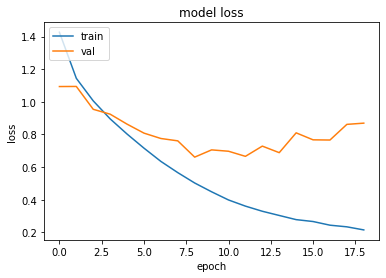

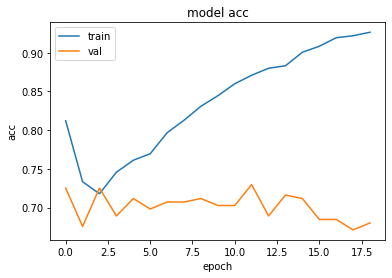

In [178]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();


In [179]:
print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TEST = model.predict(X_TEST)

pred = np.reshape(Y_PRED_TEST, (Y_PRED_TEST.shape[0],  Y_PRED_TEST.shape[1]))
#val = np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
test = np.reshape(Y_TEST, (Y_TEST.shape[0],  Y_TEST.shape[1]))

print('Confusion Matrix Validation')
print(confusion_matrix(test, np.around(pred)))
print('Test Accuracy')
print(accuracy_score(test, np.around(pred)))
print('ROC AUC SCORE Test')
print(roc_auc_score(test,pred))
print(classification_report(y_true=test, y_pred= np.around(pred)))


TARGET: mortality
Confusion Matrix Validation
[[304  69]
 [ 43  27]]
Test Accuracy
0.7471783295711061
ROC AUC SCORE Test
0.6607430103408656
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.84       373
         1.0       0.28      0.39      0.33        70

    accuracy                           0.75       443
   macro avg       0.58      0.60      0.58       443
weighted avg       0.78      0.75      0.76       443



## Add drop out and adjust learning rate

In [180]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

#from tensorflow.keras import optimizers

from tensorflow.keras.optimizers import RMSprop

def build_model1(no_feature_cols=None, time_steps=24, output_summary=False, output_bias=None):
  

  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 
  if output_bias is not None:
    output_bias = tensorflow.keras.initializers.Constant(output_bias)

  model = keras.Sequential()
  model.add(layers.LSTM(32, return_sequences=False, input_shape = (time_steps, no_feature_cols), dropout=0.6,bias_regularizer= regularizers.L1L2(l1=0.01, l2=0.01)))
  #model.add(BatchNormalization())
  model.add(layers.Dense(1, activation="sigmoid", bias_initializer = output_bias))
  optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.001, epsilon=1e-08)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model1(no_feature_cols=no_feature_cols, output_summary=True, time_steps=24, output_bias=initial_bias)
#init callbacks
tb_callback = TensorBoard(log_dir='.\\logs\\{0}.log'.format('LSTM_reg'),
    histogram_freq=0,
    write_grads=False,
    write_images=True,
    write_graph=True) 

#early stopping
callback_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  #Make checkpoint dir and init checkpointer
checkpoint_dir = "./saved_models/{0}".format('model_name')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)


#fit
history = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=16,
    epochs=100,
    callbacks=[tb_callback, callback_early], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    class_weight=class_weight,
    shuffle=True)

time_steps:24|no_feature_cols:34
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 32)                8576      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 8,609
Trainable params: 8,609
Non-trainable params: 0
_________________________________________________________________
c:\Users\Maria\Desktop\Projects Data Scripts\KTH_PROJECT_MIMIC_2021\.venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/100
97/97 [==============================] - 5s 34ms/step - loss: 1.4115 - acc: 0.8070 - val_loss: 1.0977 - val_acc: 0.7387
Epoch 2/100
97/97 [==============================] - 1s 8ms/step - loss: 1.1543 - acc: 0.7153 - val_loss: 

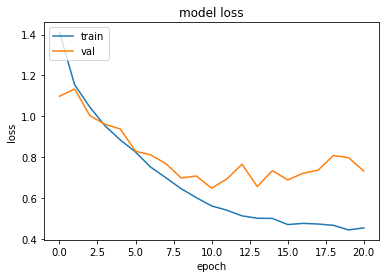

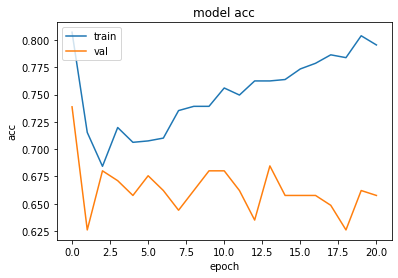

In [181]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [182]:
print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TEST = model.predict(X_TEST)

pred = np.reshape(Y_PRED_TEST, (Y_PRED_TEST.shape[0],  Y_PRED_TEST.shape[1]))
#val = np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
test = np.reshape(Y_TEST, (Y_TEST.shape[0],  Y_TEST.shape[1]))

##print('Confusion Matrix Validation')
# #print(confusion_matrix(val, pred))
print('Test Accuracy')
print(accuracy_score(test, np.around(pred)))
print('ROC AUC SCORE Test')
print(roc_auc_score(test, pred))
print('CLASSIFICATION REPORT TEST')
print(classification_report(y_true=test, y_pred= np.around(pred)))


TARGET: mortality
Test Accuracy
0.6862302483069977
ROC AUC SCORE Test
0.6380314055917273
CLASSIFICATION REPORT TEST
              precision    recall  f1-score   support

         0.0       0.88      0.72      0.80       373
         1.0       0.25      0.49      0.33        70

    accuracy                           0.69       443
   macro avg       0.57      0.60      0.56       443
weighted avg       0.78      0.69      0.72       443



## Add Batch Normalization

In [47]:
# from grid search: Best: 0.810606 using {'kc__batch_size': 32, 'kc__dense_nparams': 16, 'kc__dropout': 0.4, 'kc__l1': 0.01, 'kc__l2': 0.02}
from keras.layers import BatchNormalization
def build_model1(no_feature_cols=None, time_steps=24, output_summary=False, output_bias=None):
  

  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 
  if output_bias is not None:
    output_bias = tensorflow.keras.initializers.Constant(output_bias)
  model = keras.Sequential()
  model.add(layers.LSTM(16, return_sequences=False, input_shape = (time_steps, no_feature_cols),  kernel_regularizer= regularizers.L1L2(l1= 0.01, l2=0.02)))
  model.add(tensorflow.keras.layers.Dropout(0.4))
  model.add(BatchNormalization())
  model.add(layers.Dense(1, activation="sigmoid", bias_initializer=output_bias))
  optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.001)
  #epsilon=1e-08
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model

In [48]:
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model1(no_feature_cols=no_feature_cols, output_summary=True, time_steps=24, output_bias=initial_bias)
#init callbacks
tb_callback = TensorBoard(log_dir='.\\logs\\{0}.log'.format('LSTM_reg'),
histogram_freq=0,
write_grads=False,
write_images=True,
write_graph=True) 

#early stopping
callback_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  #Make checkpoint dir and init checkpointer
checkpoint_dir = "./saved_models/{0}".format('model_name')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)


#fit
history = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=32,
    epochs=200,
    callbacks=[tb_callback, callback_early], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    class_weight=class_weight,
    shuffle=True)

time_steps:24|no_feature_cols:34
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                3264      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,345
Trainable params: 3,313
Non-trainable params: 32
_________________________________________________________________
c:\Users\Maria\Desktop\Projects Data Scripts\KTH_PROJECT_MIMIC_2021\.venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` 

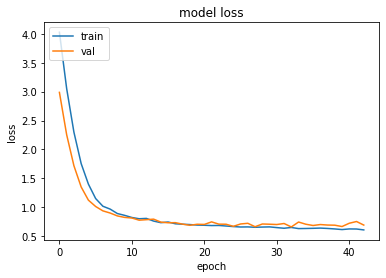

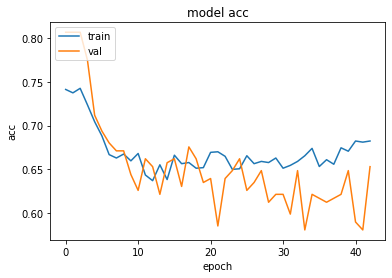

In [49]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TEST = model.predict(X_TEST)

pred = np.reshape(Y_PRED_TEST, (Y_PRED_TEST.shape[0],  Y_PRED_TEST.shape[1]))
#val = np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
test = np.reshape(Y_TEST, (Y_TEST.shape[0],  Y_TEST.shape[1]))

print('Confusion Matrix Validation')
print(confusion_matrix(test, np.around(pred)))
print('Test Accuracy')
print(accuracy_score(test, np.around(pred)))
print('ROC AUC SCORE Test')
print(roc_auc_score(test,pred))
print(classification_report(y_true=test, y_pred= np.around(pred)))


TARGET: mortality
Confusion Matrix Validation
[[244 129]
 [ 31  39]]
Test Accuracy
0.6388261851015802
ROC AUC SCORE Test
0.6889314438912295
              precision    recall  f1-score   support

         0.0       0.89      0.65      0.75       373
         1.0       0.23      0.56      0.33        70

    accuracy                           0.64       443
   macro avg       0.56      0.61      0.54       443
weighted avg       0.78      0.64      0.69       443



In [144]:
tn, fp, fn, tp = confusion_matrix(test, np.around(pred)).ravel()

In [145]:
tn

259

In [146]:
tp

36

In [147]:
fp

114

In [148]:
fn

34

### results from the previous run, without initial bias

In [90]:
print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TEST = model.predict(X_TEST)

pred = np.reshape(Y_PRED_TEST, (Y_PRED_TEST.shape[0],  Y_PRED_TEST.shape[1]))
#val = np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
test = np.reshape(Y_TEST, (Y_TEST.shape[0],  Y_TEST.shape[1]))

print('Confusion Matrix Validation')
print(confusion_matrix(test, np.around(pred)))
print('Test Accuracy')
print(accuracy_score(test, np.around(pred)))
print('ROC AUC SCORE Test')
print(roc_auc_score(test,pred))

TARGET: mortality
Confusion Matrix Validation
[[357  16]
 [ 61   9]]
Test Accuracy
0.8261851015801355
ROC AUC SCORE Test
0.6316353887399465


## Grid search 

In [51]:

def build_model1(dense_nparams, dropout, l1, l2,  no_feature_cols=no_feature_cols, time_steps=24, output_summary=True, output_bias=None):
  

  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 
  if output_bias is not None:
    output_bias = tensorflow.keras.initializers.Constant(output_bias)

  model = keras.Sequential()
  model.add(layers.LSTM(dense_nparams, return_sequences=False, input_shape = (time_steps, no_feature_cols), dropout=dropout, bias_regularizer= regularizers.L1L2(l1=l1, l2=l2)))
  #model.add(BatchNormalization())
  model.add(layers.Dense(1, activation="sigmoid", bias_initializer = output_bias))
  optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.001, epsilon=1e-08)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model

In [52]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [53]:
keras_estimator = KerasClassifier(build_fn=build_model1, verbose=1)


In [54]:
estimator = Pipeline([("kc", keras_estimator)])

In [55]:
# define the grid search parameters
param_grid = {
    #'kc__epochs': [100, 200, ],
    'kc__dense_nparams': [16, 32],
    'kc__batch_size':[2, 16, 32, 64, 512],
    'kc__l1':[0.01, 0.02, 0.03],
    'kc__l2':[0.01,0.02, 0.02],
    'kc__dropout': [0.5, 0.4, 0.3, 0.2, 0.1, 0],
    #'kc__dropout': [0.5],
}

In [56]:
kfold_splits = 5
grid = GridSearchCV(estimator=estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    cv=kfold_splits,  #StratifiedKFold(n_splits=kfold_splits, shuffle=True)
                    param_grid=param_grid,)

In [59]:
#grid_result = grid.fit(X_VAL, Y_VAL) #callbacks=[tbCallBack]

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for means, stds, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (means, stds, param))

Best: 0.806263 using {'kc__batch_size': 512, 'kc__dense_nparams': 16, 'kc__dropout': 0, 'kc__l1': 0.01, 'kc__l2': 0.02}
0.585455 (0.187338) with: {'kc__batch_size': 2, 'kc__dense_nparams': 16, 'kc__dropout': 0.5, 'kc__l1': 0.01, 'kc__l2': 0.01}
0.612121 (0.225371) with: {'kc__batch_size': 2, 'kc__dense_nparams': 16, 'kc__dropout': 0.5, 'kc__l1': 0.01, 'kc__l2': 0.02}
0.640101 (0.116055) with: {'kc__batch_size': 2, 'kc__dense_nparams': 16, 'kc__dropout': 0.5, 'kc__l1': 0.01, 'kc__l2': 0.02}
0.595455 (0.214063) with: {'kc__batch_size': 2, 'kc__dense_nparams': 16, 'kc__dropout': 0.5, 'kc__l1': 0.02, 'kc__l2': 0.01}
0.761111 (0.079384) with: {'kc__batch_size': 2, 'kc__dense_nparams': 16, 'kc__dropout': 0.5, 'kc__l1': 0.02, 'kc__l2': 0.02}
0.681313 (0.150605) with: {'kc__batch_size': 2, 'kc__dense_nparams': 16, 'kc__dropout': 0.5, 'kc__l1': 0.02, 'kc__l2': 0.02}
0.652727 (0.161554) with: {'kc__batch_size': 2, 'kc__dense_nparams': 16, 'kc__dropout': 0.5, 'kc__l1': 0.03, 'kc__l2': 0.01}
0.482